In [1]:
%matplotlib notebook

In [2]:
import pandas as pd
import numpy as np
from pip import main
from os import walk
from os.path import join
main(['install', '--upgrade', 'matplotlib'])
main(['install', '--upgrade', 'scipy'])
main(['install', 'word2vec'])
main(['install', 'gensim'])
main(['install', 'imbalanced-learn'])
import gensim
import re
from math import ceil
from collections import Counter
import operator
import matplotlib.pyplot as plt

Requirement already up-to-date: matplotlib in /usr/local/lib/python2.7/dist-packages
Requirement already up-to-date: pytz in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Requirement already up-to-date: cycler in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Requirement already up-to-date: python-dateutil in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Requirement already up-to-date: pyparsing!=2.0.0,!=2.0.4,!=2.1.2,>=1.5.6 in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Requirement already up-to-date: numpy>=1.6 in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Requirement already up-to-date: six in /usr/local/lib/python2.7/dist-packages (from cycler->matplotlib)
Requirement already up-to-date: scipy in /usr/local/lib/python2.7/dist-packages
'pattern' package not found; tag filters are not available for English


/usr/local/lib/python2.7/dist-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [3]:
main(['install', 'imbalanced-learn'])

0

In [4]:
import matplotlib.pyplot as plt

In [5]:
# data_path = "IMDB_reviews.tsv"
# df = pd.read_csv(data_path, sep='\t')
# df['class'] = df.id.apply(lambda s: s.split('_')[1]).astype('int')
# df['id'] = df.id.apply(lambda s: s.split('_')[0]).astype('int')

In [6]:
data_path = "sentiment_restaurant.csv"
df = pd.read_csv(data_path, sep=',')
df.columns = ['sentiment', 'review']
df = df[:2000000]

In [7]:
def get_train_val_test_inds(y,train_proportion=0.8, val_proportion=0.1):
    '''
    stratified sampling
    '''
    if train_proportion + val_proportion >= 1:
        raise Exception("")
    y=np.array(y)
    train_inds = np.zeros(len(y),dtype=bool)
    val_inds = np.zeros(len(y),dtype=bool)
    test_inds = np.zeros(len(y),dtype=bool)
    values = np.unique(y)
    for value in values:
        value_inds = np.nonzero(y==value)[0]
        np.random.shuffle(value_inds)
        n1 = int(train_proportion * len(value_inds))
        n2 = n1 + int((val_proportion) * len(value_inds))

        train_inds[value_inds[:n1]]=True
        val_inds[value_inds[n1:n2]]=True
        test_inds[value_inds[n2:]]=True

    return train_inds, val_inds, test_inds

In [115]:
train_inds, val_inds, test_inds = get_train_val_test_inds(df.sentiment)
DF_train, DF_val, DF_test = df[train_inds], df[val_inds], df[test_inds]

In [9]:
vec_size = 300
def words_tokenizer(text_series):
    regex = re.compile('[^a-zA-Z ]')
    result = []
    for text in text_series:
        result.append(re.sub(regex, '', text).lower())
    return result

In [10]:
def get_words_dict(df, vocab, topN=100000):
    counter = Counter(re.findall(r"[\w']+", " ".join(words_tokenizer(df.review))))
    words_dict = list(filter(lambda (w, c): len(w) >= 2, counter.items()))
    common = set(vocab.keys()).intersection(set(map(operator.itemgetter(0), words_dict)))
    words_dict = list(filter(lambda (w, c): w in common, words_dict))
    words_dict = sorted(words_dict, key=operator.itemgetter(1), reverse=True)[:topN]
    words_dict = dict((pair[0], i) for i, pair in enumerate(words_dict))
    return words_dict, common

In [11]:
model = gensim.models.Word2Vec.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

loading projection weights from GoogleNews-vectors-negative300.bin
loaded (3000000, 300) matrix from GoogleNews-vectors-negative300.bin


In [12]:
words_dict, common_words = get_words_dict(df, model.vocab)

In [13]:
embeddings_matrix = model.syn0[[model.vocab[word].index for word in common_words]]
common_words = list(common_words)
trimmed_dict = dict((x, i) for i,x in enumerate(common_words))
# from pickle import load
# with open('embeddings.pkl', 'r') as f:
#     model = load(f)
# embeddings = model['embeddings']
# dictionary = model['dictionary']

# common_words = set(words_dict.keys()).intersection(set(dictionary.keys()))
# embeddings_matrix = embeddings[[dictionary[word] for word in common_words]]
# common_words = list(common_words)
# trimmed_dict = dict((x, i) for i,x in enumerate(common_words))
# reverse_dict = dict((i, x) for i,x in enumerate(common_words))

In [14]:
len(common_words)

94653

In [15]:
def word_2_vec(model, word):
    if word in model:
        return model[word]
    return None

def text_2_vec(text):
    regex = re.compile('[^a-zA-Z ]')
    words = re.sub(regex, '', text).lower().split()
    res = np.zeros((0, vec_size))
    for word in words:
        vec = word_2_vec(model, word)
        if vec is not None:
            res = np.vstack((res, vec.reshape(1, vec_size)))
    return res

# def word_2_vec(word):
#     if word in dictionary:
#         return embeddings[dictionary[word]]
#     return None

# def text_2_vec(text):
#     regex = re.compile('[^a-zA-Z ]')
#     words = re.sub(regex, '', text).lower().split()
#     res = np.zeros((0, vec_size))
#     for word in words:
#         vec = word_2_vec(word)
#         if vec is not None:
#             res = np.vstack((res, vec.reshape(1, vec_size)))
#     return res

def word_2_id(word):
    if word in trimmed_dict:
        return np.array(trimmed_dict[word])
    return None

def text_2_id(text):
    regex = re.compile('[^a-zA-Z ]')
    words = re.sub(regex, '', text).lower().split()
    res = np.zeros((0, 1), dtype='int32')
    for word in words:
        vec = word_2_id(word)
        if vec is not None:
            res = np.vstack((res, vec))
    return res

In [16]:
def get_data_block(df, block_size=1000, shift=0, max_len=None):
    X_temp = [0] * min(block_size, len(df))
    for i in range(min(block_size, len(df) - shift)):
        vec = text_2_id(df.iloc[shift + i].review)
        X_temp[i] = vec
    X_temp = np.array(X_temp)
    if max_len is None:
        max_len = max(map(lambda x: len(x), X_temp))
    X = np.zeros((len(X_temp), max_len))
    for i in range(len(X_temp)):
#         X[i,:X_temp[i].shape[0],:] = X_temp[i]
        temp_vec = X_temp[i][:min(max_len, X_temp[i].shape[0])]
        X[i,:min(max_len, X_temp[i].shape[0])] = temp_vec.reshape((len(temp_vec),))
    Y = df.sentiment[shift:shift + len(X)] / 5
    Y.reset_index(drop=True, inplace=True)
    Y = pd.DataFrame(Y)
    return X, Y.as_matrix(), max_len

In [17]:
import keras.models
from keras.models import Sequential
from keras.layers import Dense, Masking, Dropout, Embedding
from keras.layers import TimeDistributed, Flatten, Merge
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU, LSTM, SimpleRNN
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2, activity_l2, l1, activity_l1
from keras.optimizers import Adam, Nadam
from keras import backend as K

Using Theano backend.
Using gpu device 0: GeForce GTX 660 (CNMeM is enabled with initial size: 50.0% of memory, cuDNN not available)


In [18]:
def plt_update(fig, ax, y, colors=['b']):
    x = np.linspace(0,1,len(y))
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(x)
            line.set_ydata(y)
    else:
        for color in colors:
            ax.plot(x, y, color)
    fig.canvas.draw()

In [19]:
from sklearn.metrics import accuracy_score

In [20]:
def train_rnn(DF_train, Keras_model, max_len, X_val, Y_val):
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('iteration')
    ax.set_ylabel('loss')
    ax.set_xlim(0,1)
    ax.set_ylim(0.0,0.5)
    loss_series = []    
    block_size = 80
    nb_epoch = 1
    for epoch in range(nb_epoch):
        total_cnt = 0
        rigth_cnt = 0
        for i in range(int(ceil(len(DF_train) * 1.0 / block_size))):
            shift = i * block_size
            cur_size = min(block_size, len(DF_train) - shift)
            X_train, Y_train, _ = get_data_block(DF_train, shift=shift, block_size=cur_size, max_len=max_len)
            metrics = Keras_model.train_on_batch(X_train, Y_train)
            total_cnt += block_size
            rigth_cnt += int(metrics[1].item() * block_size)
            accuracy = rigth_cnt * 1.0 / total_cnt
            loss = metrics[0].item()
            loss_series += [loss]
            plt_update(fig, ax, loss_series)
#             print("Epoch %s, batch %s, results %s" % (epoch, i, [metrics[0].item(), accuracy]))
        loss_and_metrics = Keras_model.evaluate(X_val, Y_val, batch_size=block_size)
        print(loss_and_metrics)

def test_rnn(X_val, Y_val, Keras_model):
    loss_and_metrics = Keras_model.evaluate(X_val, Y_val, batch_size=80)
    print(loss_and_metrics)

In [21]:
max_len = 200

In [22]:
Keras_model = Sequential()
# M = Masking(mask_value=0,input_shape=(max_len, vec_size))
# Keras_model.add(M)
Keras_model.add(Embedding(len(embeddings_matrix),
                            vec_size,
                            weights=[embeddings_matrix],
                            input_length=max_len,
                            trainable=True))
Keras_model.add(LSTM(vec_size, return_sequences=False))
Keras_model.add(Dropout(0.5))
Keras_model.add((Dense(output_dim=100, activation='tanh')))
Keras_model.add(Dropout(0.5))
Keras_model.add((Dense(output_dim=20, activation='tanh')))
Keras_model.add(Dropout(0.5))
Keras_model.add((Dense(output_dim=2, activation='tanh')))
# Keras_model.add(Dropout(0.5))
# Keras_model.add(GlobalAveragePooling1D())
Keras_model.add(Dropout(0.5))
# Keras_model.add(BatchNormalization())
Keras_model.add(Dense(1, activation="tanh")) #W_regularizer=l1(0.01), activity_regularizer=activity_l1(0.01)
optimizer = Adam(lr=0.0001)
Keras_model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

In [125]:
# from imblearn.under_sampling import AllKNN
# allknn = AllKNN()
import imblearn
imblearn = reload(imblearn)
def undersample(df):
    under_sampler = imblearn.RandomUnderSampler()
    DF_train_indices = pd.DataFrame(range(len(df)))
    X_train = np.expand_dims(DF_train_indices.as_matrix(), axis=1)
    Y_train = df.sentiment.as_matrix()
    DF_train_resampled_idx, _ = under_sampler.fit_sample(X_train, Y_train)
    DF_train_resampled = DF_train.iloc[np.squeeze(DF_train_resampled_idx)]
    DF_train_resampled = DF_train_resampled.iloc[np.random.permutation(np.arange(len(DF_train_resampled)))]
    return DF_train_resampled

In [129]:
DF_train_resampled = undersample(DF_train)

Compute classes statistics ...
5 classes detected: Counter({5: 620112, 4: 428937, 3: 206056, 1: 204437, 2: 140456})
Under-sampling performed: Counter({1: 140456, 2: 140456, 3: 140456, 4: 140456, 5: 140456})


In [128]:
DF_val_resampled = undersample(DF_val)

Compute classes statistics ...
5 classes detected: Counter({5: 77514, 4: 53617, 3: 25757, 1: 25554, 2: 17557})
Under-sampling performed: Counter({1: 17557, 2: 17557, 3: 17557, 4: 17557, 5: 17557})


In [130]:
X_val, Y_val, _ = get_data_block(DF_val_resampled, shift=0, block_size=len(DF_val_resampled), max_len=max_len)

<IPython.core.display.Javascript object>


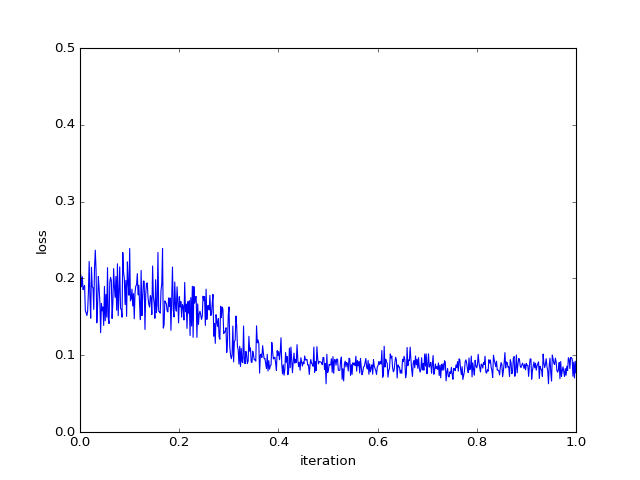

In [ ]:
train_rnn(DF_train_resampled, Keras_model, max_len, X_val, Y_val)

In [ ]:
X_test, Y_test, _ = get_data_block(DF_test, shift=0, block_size=2500, max_len=max_len)

In [ ]:
test_rnn(X_test, Y_test, Keras_model)

In [ ]:
Y_pred = Keras_model.predict(X_val, batch_size=80)

In [ ]:
diff_val = (abs(Y_pred - Y_val))
print(len(diff_val[diff_val <= 0.4]) * 1.0 /len(diff_val))

In [ ]:
np.hstack((Y_pred, Y_val))

In [ ]:
(abs(Y_pred - Y_val)).mean()

In [ ]:
from pickle import dump
with open("sentiment_model.pkl", "w+") as f:
    dump(trimmed_dict, f)

In [ ]:
Keras_model.save("sentiment_model_keras.pkl")

In [ ]:
X_test, Y_test, _ = get_data_block(DF_train[DF_train.sentiment < 3], shift=0, block_size=100000, max_len=max_len)

In [ ]:
test_rnn(X_test, Y_test, Keras_model)

In [ ]:
Y_pred = Keras_model.predict(X_test, batch_size=80)

In [ ]:
diff_val = (abs(Y_pred - Y_test))
print(len(diff_val[diff_val <= 0.3]) * 1.0 /len(diff_val))

In [ ]:
text = ""

In [ ]:
def calc_sentiment(text):
    input_len = Keras_model.layers[0].input_shape[1] # 200
    vec_id = text_2_id(text)
    if len(vec_id) < input_len:
        vec_id_tmp = np.zeros((1, input_len))
        vec_id_tmp[:,:len(vec_id)] = np.array(vec_id).reshape((1, len(vec_id)))
        vec_id = vec_id_tmp
    begin_i = 0
    end_i = min(len(vec_id), input_len)
    sentiment_res = []
    while end_i <= len(vec_id):
        text_df = np.array(vec_id[begin_i:end_i]).reshape((1, input_len))
        sent = Keras_model.predict(text_df, batch_size=1)[0][0]
        sentiment_res += [sent]
        if end_i == len(vec_id):
            break
        end_i = min(end_i + input_len, len(vec_id))
        begin_i = end_i - input_len
    if len(sentiment_res) > 1:
        sentiment_res[-2] = (sentiment_res[-2] + sentiment_res[-1]) / 2
        del sentiment_res[-1]
    return np.array(sentiment_res).mean()

In [ ]:
calc_sentiment(text)

In [ ]:
Keras_model.layers[0].input_shape[1]

In [ ]:
from sklearn.decomposition import TruncatedSVD, PCA

In [ ]:
word_top={'some', 'that', 'good', 'film', 'they', 'what', 'movie', 'would', 'just', 'even', 'from', 'there', 'when', 'like', 'about', 'with', 'very', 'this', 'have', 'more'}

tsne = TruncatedSVD(n_components=2)
two_d_embeddings = tsne.fit_transform(embeddings[target_indices, :])
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(12,12))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  plt.show()

plot(two_d_embeddings, word_top)

In [ ]:
block_size = 2
shift = 10
X_temp = [0] * min(block_size, len(df))
for i in range(min(block_size, len(df) - shift)):
    vec = text_2_id(df.iloc[shift + i].review)
    X_temp[i] = vec
X_temp = np.array(X_temp)
if max_len is None:
    max_len = max(map(lambda x: len(x), X_temp))
X = np.zeros((len(X_temp), max_len))
for i in range(len(X_temp)):
#         X[i,:X_temp[i].shape[0],:] = X_temp[i]
    temp_vec = X_temp[i][:min(max_len, X_temp[i].shape[0])]
    X[i,:min(max_len, X_temp[i].shape[0])] = temp_vec.reshape((len(temp_vec),))
Y = df.sentiment[shift:shift + len(X)]
Y.reset_index(drop=True, inplace=True)
Y = pd.DataFrame(Y)
pd.DataFrame(Y)['not_sentiment'] = np.abs(Y-1)
Y = Y.as_matrix()

In [ ]:
" ".join(map(lambda x: reverse_dict[x[0]], X_temp[1])), Y[1]

In [ ]:
df.review[11], df.sentiment[11]

In [ ]:
reverse_dict[0]